In [130]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [199]:
flights.dtypes

YEAR                     int64
MONTH                    int64
DAY                      int64
DAY_OF_WEEK              int64
AIRLINE                 object
FLIGHT_NUMBER            int64
TAIL_NUMBER             object
ORIGIN_AIRPORT          object
DESTINATION_AIRPORT     object
SCHEDULED_DEPARTURE      int64
DEPARTURE_TIME         float64
DEPARTURE_DELAY        float64
TAXI_OUT               float64
WHEELS_OFF             float64
SCHEDULED_TIME         float64
ELAPSED_TIME           float64
AIR_TIME               float64
DISTANCE                 int64
WHEELS_ON              float64
TAXI_IN                float64
SCHEDULED_ARRIVAL        int64
ARRIVAL_TIME           float64
ARRIVAL_DELAY          float64
DIVERTED                 int64
CANCELLED                int64
CANCELLATION_REASON     object
AIR_SYSTEM_DELAY       float64
SECURITY_DELAY         float64
AIRLINE_DELAY          float64
LATE_AIRCRAFT_DELAY    float64
WEATHER_DELAY          float64
late_departure            bool
late_arr

In [2]:
# Load up airports
airports = pd.read_csv('airports.csv')
airports.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [9]:
airports.shape

(322, 7)

In [215]:
# Load up flights
flights = pd.read_csv("flights.csv",dtype={"ORIGIN_AIRPORT":str,"DESTINATION_AIRPORT":str})
flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [219]:
flights.ORIGIN_AIRPORT.unique()

array(['ANC', 'LAX', 'SFO', 'SEA', 'LAS', 'DEN', 'SLC', 'PDX', 'FAI',
       'MSP', 'PHX', 'SJU', 'PBG', 'IAG', 'PSE', 'BQN', 'ORD', 'GEG',
       'HNL', 'ONT', 'MCO', 'BOS', 'HIB', 'ABR', 'MAF', 'DFW', 'MKE',
       'IAH', 'BNA', 'BRO', 'VPS', 'BOI', 'BJI', 'SGF', 'PHL', 'SBN',
       'RDD', 'EUG', 'IAD', 'BUF', 'PWM', 'JFK', 'CRP', 'PIA', 'FAT',
       'SMF', 'AUS', 'MCI', 'ATL', 'JAX', 'MFR', 'IDA', 'MSN', 'DCA',
       'SAT', 'CHS', 'SBA', 'SMX', 'IND', 'CLE', 'GSP', 'BDL', 'ABI',
       'RIC', 'BFL', 'OMA', 'RDM', 'FLL', 'CID', 'TPA', 'SYR', 'ROC',
       'TYR', 'LAN', 'XNA', 'GSO', 'EWR', 'PBI', 'RSW', 'OAK', 'PVD',
       'RNO', 'PIT', 'ABQ', 'MIA', 'BWI', 'LGA', 'TUL', 'LIT', 'MSY',
       'OKC', 'ATW', 'PNS', 'MEM', 'TYS', 'MHT', 'SAV', 'CLT', 'GRB',
       'ABE', 'JAN', 'OAJ', 'FAR', 'ERI', 'LEX', 'CWA', 'MSO', 'TTN',
       'AMA', 'CLL', 'HOU', 'JLN', 'MLI', 'RDU', 'CVG', 'MHK', 'MOB',
       'TLH', 'BHM', 'CAE', 'TXK', 'ACY', 'DTW', 'RAP', 'TUS', 'EAU',
       'DLH', 'FSD',

In [ ]:
flights.iloc()

In [50]:
# Problem we have airports not in the airport list: 
#flights["DESTINATION_AIRPORT"].value_counts()
#flights["ORIGIN_AIRPORT"].value_counts()
# solution => filter them out
codes = list(airports["IATA_CODE"])
destsize = flights[flights["DESTINATION_AIRPORT"].isin(codes)]["DESTINATION_AIRPORT"].value_counts().sort_index().to_numpy()
deptsize = flights[flights["ORIGIN_AIRPORT"].isin(codes)]["ORIGIN_AIRPORT"].value_counts().sort_index().to_numpy()

# generate true/false for departure delay
flights["late_departure"] = [True if x <= 0 else False for x in flights["DEPARTURE_DELAY"]]
flights["late_arrival"] = [True if x <= 0 else False for x in flights["ARRIVAL_DELAY"]]
# get overview
delaydf = flights.pivot_table("late_departure",index="ORIGIN_AIRPORT")
departdf = flights.pivot_table("late_arrival",index="ORIGIN_AIRPORT")
# delay ratios
delaydf = pd.concat([delaydf, departdf], axis=1).loc[codes].sort_index();

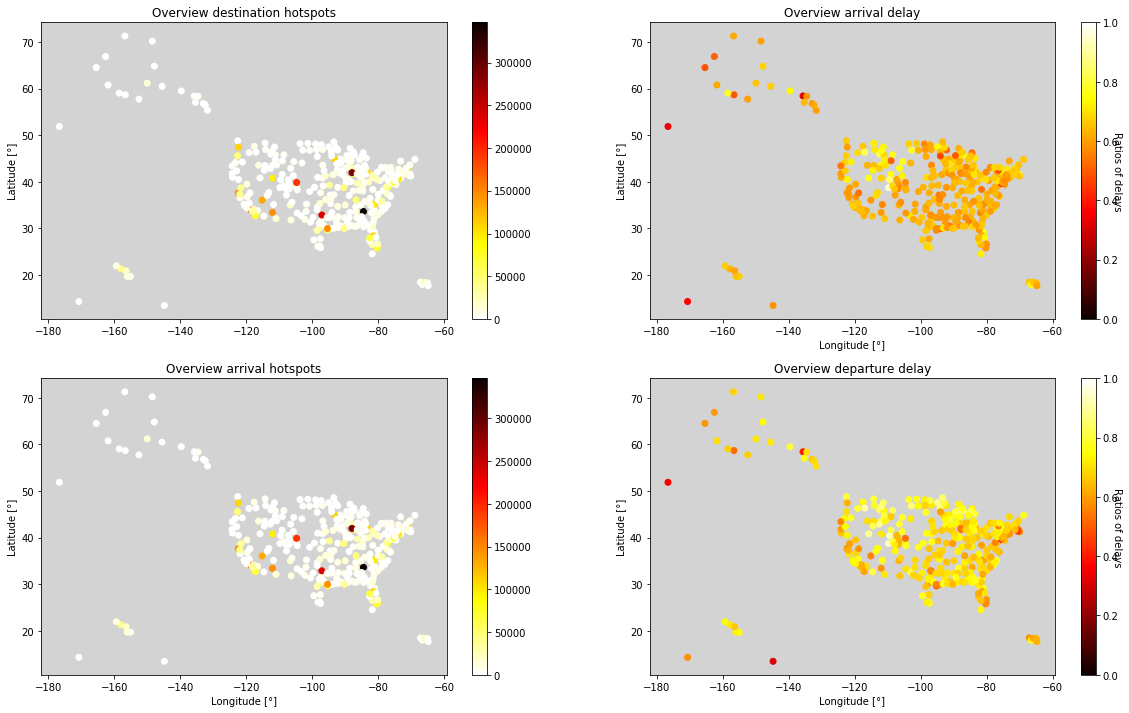

In [197]:
# generate graphical representation
x = airports.sort_values(by="IATA_CODE")["LONGITUDE"].to_numpy()
y = airports.sort_values(by="IATA_CODE")["LATITUDE"].to_numpy()

plt.figure(figsize=(20,12))
plt.subplot(2,2,1)
ax = plt.gca()
ax.set_facecolor('lightgrey')
plt.scatter(x,y,c=destsize,cmap="hot_r")
#plt.xlabel("Longitude [°]")
plt.ylabel("Latitude [°]")
plt.title("Overview destination hotspots");
plt.colorbar();
plt.clim(0,max(np.max(deptsize),np.max(destsize)))

#plt.figure(figsize=(15,8))
plt.subplot(2,2,3)
ax = plt.gca()
ax.set_facecolor('lightgrey')
plt.scatter(x,y,c=deptsize,cmap="hot_r")
plt.xlabel("Longitude [°]")
plt.ylabel("Latitude [°]")
plt.title("Overview arrival hotspots");
plt.colorbar();
plt.clim(0,max(np.max(deptsize),np.max(destsize)))

# plot arrival/departure times
#plt.figure(figsize=(15,8))
plt.subplot(2,2,4)
ax = plt.gca()
ax.set_facecolor('lightgrey')
plt.scatter(x,y,c=delaydf["late_departure"].to_numpy(),cmap="hot")
plt.xlabel("Longitude [°]")
plt.ylabel("Latitude [°]")
plt.title("Overview departure delay");
cbar = plt.colorbar();
cbar.set_label('Ratios of delays', rotation=270)
plt.clim(0,1)

#plt.figure(figsize=(15,8))
plt.subplot(2,2,2)
ax = plt.gca()
ax.set_facecolor('lightgrey')
plt.scatter(x,y,c=delaydf["late_arrival"].to_numpy(),cmap="hot")
plt.xlabel("Longitude [°]")
plt.ylabel("Latitude [°]")
plt.title("Overview arrival delay");
cbar = plt.colorbar();
cbar.set_label('Ratios of delays', rotation=270)
plt.clim(0,1)


In [178]:
# Number of airports per state
airports.groupby('STATE').count().sort_values(by=['COUNTRY'],ascending=False).head()

,IATA_CODE,AIRPORT,CITY,COUNTRY,LATITUDE,LONGITUDE
STATE,,,,,,
TX,24,24,24,24,24,24
CA,22,22,22,22,22,22
AK,19,19,19,19,19,19
FL,17,17,17,17,15,15
MI,15,15,15,15,15,15


Text(0, 0.5, 'Probability density polot for departure delay')

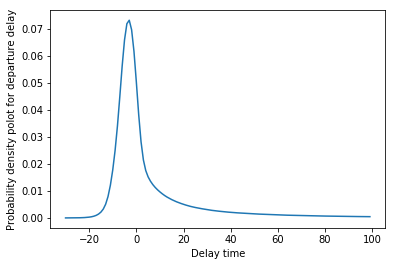

In [195]:
a = flights["DEPARTURE_DELAY"].dropna().to_numpy()
kernel = stats.gaussian_kde(a)
x = np.arange(-30,100)
y = kernel(x)
plt.plot(x,y)
plt.xlabel("Delay time")
plt.ylabel("Probability density polot for departure delay")

In [202]:

tes = flights["DESTINATION_AIRPORT"]

In [206]:
type(tes)

pandas.core.series.Series

In [210]:

len(tes)

5819079

In [225]:
# Load flight data
df_fl = pd.read_csv("flights.csv",dtype={"ORIGIN_AIRPORT":str,"DESTINATION_AIRPORT":str})
len(df_fl)

5819079

In [227]:
# Fix the airport 5-digit > 3-letter code
df_aircode1 = pd.read_csv('L_AIRPORT.csv')
df_aircode2 = pd.read_csv('L_AIRPORT_ID.csv')

# Format the airport codes
df_aircode1 = df_aircode1.reset_index()
df_aircode2 = df_aircode2.reset_index()
df_aircodes = pd.merge(df_aircode1,df_aircode2,on='Description')
aircode_dict = dict(zip(df_aircodes['Code_y'].astype(str),df_aircodes['Code_x']))

def mymapper(label,dic):
    # check length
    if len(label) == 3:
        return label
    else:
        return aircode_dict[label]
        

In [ ]:
mymapper()

In [ ]:


# Actual replacement
N_flights = len(df_fl)
for i in range(N_flights):
    if i % 100000 == 0:
        print(i)
    if len(df_fl['ORIGIN_AIRPORT'][i]) != 3:
        to_replace = df_fl['ORIGIN_AIRPORT'][i]
        value = aircode_dict[df_fl['ORIGIN_AIRPORT'][i]]
        df_fl = df_fl.replace(to_replace, value)
        print('replaced',to_replace,'with',value)
    elif len(df_fl['DESTINATION_AIRPORT'][i]) != 3:
        to_replace = df_fl['DESTINATION_AIRPORT'][i]
        value = aircode_dict[df_fl['DESTINATION_AIRPORT'][i]]
        df_fl = df_fl.replace(to_replace, value)
        print('replaced',to_replace,'with',value)